# Shoes Image Classification (5 classes)
Dataset folders: `shoes_dataset/Shoes Dataset/Train`, `Valid`, `Test`.

Ce notebook est *corrigé* pour éviter les erreurs de variables non définies : exécutez **Kernel → Restart Kernel and Run All**.

In [2]:
# 1) Imports + configuration
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

print("TensorFlow:", tf.__version__)

SEED = 123
tf.random.set_seed(SEED)

IMG_SIZE = (224, 224)      # (height, width)
BATCH_SIZE = 32


ModuleNotFoundError: No module named 'tensorflow'

In [ ]:
# 2) Chemins dataset (adaptés pour votre machine Linux)
train_dir = "Shoes Dataset/Train"
val_dir   = "Shoes Dataset/Valid"
test_dir  = "Shoes Dataset/Test"

import os
print("CWD:", os.getcwd())
print("Train exists?", os.path.isdir(train_dir))
print("Valid exists?", os.path.isdir(val_dir))
print("Test exists?", os.path.isdir(test_dir))

In [3]:
# 3) Charger les datasets depuis les dossiers
train_ds = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    seed=SEED
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    val_dir,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    seed=SEED,
    shuffle=False
)

test_ds = tf.keras.utils.image_dataset_from_directory(
    test_dir,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=False
)

class_names = train_ds.class_names
num_classes = len(class_names)
print("Classes:", class_names, "| num_classes:", num_classes)


Found 10000 files belonging to 5 classes.
Found 2500 files belonging to 5 classes.
Found 1215 files belonging to 5 classes.
Classes: ['Ballet Flat', 'Boat', 'Brogue', 'Clog', 'Sneaker'] | num_classes: 5


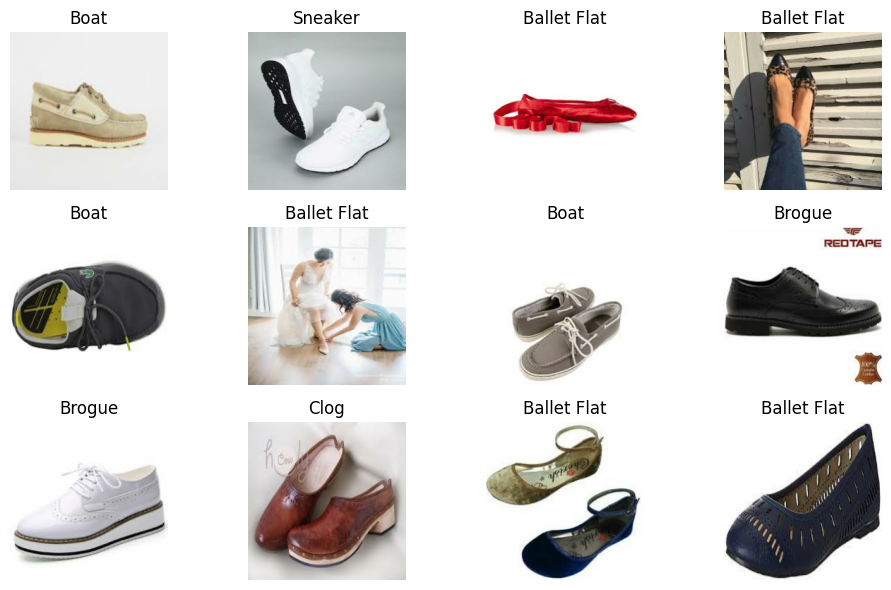

In [4]:
# 4) Visualiser quelques images (sanity check)
plt.figure(figsize=(10, 6))
for images, labels in train_ds.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[int(labels[i])])
        plt.axis("off")
plt.tight_layout()
plt.show()


In [6]:
# 5) Pré-processing + data augmentation
from tensorflow.keras import layers

rescale = layers.Rescaling(1./255)

data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.05),
    layers.RandomZoom(0.1),
    layers.RandomContrast(0.1),
], name="data_augmentation")


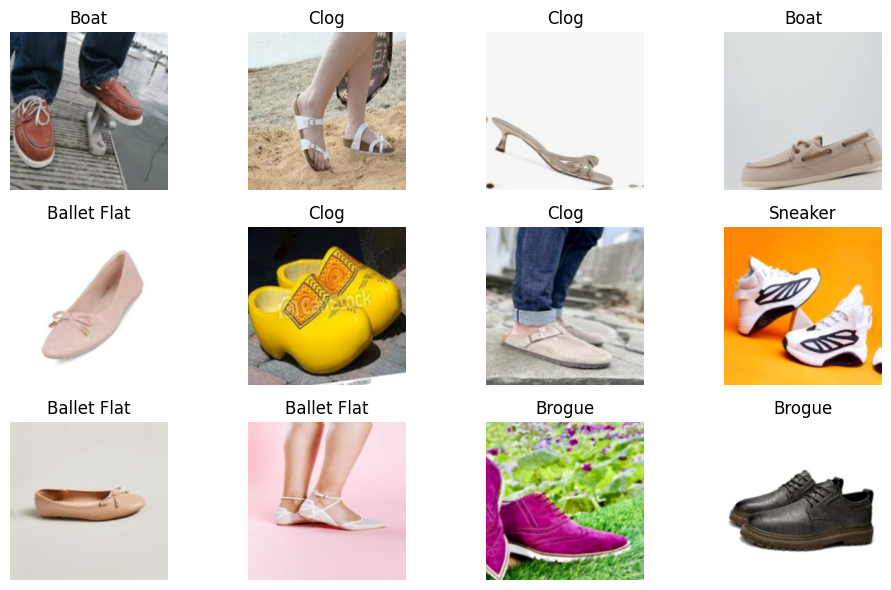

In [7]:
# 6) Vérifier visuellement l'augmentation
plt.figure(figsize=(10, 6))
for images, labels in train_ds.take(1):
    aug = data_augmentation(images)
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(aug[i].numpy().astype("uint8"))
        plt.title(class_names[int(labels[i])])
        plt.axis("off")
plt.tight_layout()
plt.show()


In [8]:
# 7) Pipeline performant (cache/prefetch)
AUTOTUNE = tf.data.AUTOTUNE
train_ds_perf = train_ds.cache().shuffle(1000, seed=SEED).prefetch(AUTOTUNE)
val_ds_perf   = val_ds.cache().prefetch(AUTOTUNE)
test_ds_perf  = test_ds.cache().prefetch(AUTOTUNE)


In [9]:
# 8) CNN "from scratch"
from tensorflow.keras import models

cnn = models.Sequential([
    layers.Input(shape=(IMG_SIZE[0], IMG_SIZE[1], 3)),
    data_augmentation,
    rescale,

    layers.Conv2D(32, 3, padding="same", activation="relu"),
    layers.MaxPooling2D(),

    layers.Conv2D(64, 3, padding="same", activation="relu"),
    layers.MaxPooling2D(),

    layers.Conv2D(128, 3, padding="same", activation="relu"),
    layers.MaxPooling2D(),

    layers.Dropout(0.3),
    layers.Flatten(),
    layers.Dense(128, activation="relu"),
    layers.Dropout(0.3),
    layers.Dense(num_classes, activation="softmax")
], name="cnn_scratch")

cnn.compile(
    optimizer=tf.keras.optimizers.Adam(1e-3),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

cnn.summary()


Model: "cnn_scratch"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ data_augmentation (Sequential)  │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_1 (Rescaling)         │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 100352)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │    12,845,184 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,939,077 (49.36 MB)

 Trainable params: 12,939,077 (49.36 MB)

 Non-trainable params: 0 (0.00 B)

In [10]:
# 9) Entraînement
early = tf.keras.callbacks.EarlyStopping(
    monitor="val_accuracy",
    patience=5,
    restore_best_weights=True
)

hist_cnn = cnn.fit(
    train_ds_perf,
    validation_data=val_ds_perf,
    epochs=20,
    callbacks=[early]
)


Epoch 1/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 247s 735ms/step - accuracy: 0.3058 - loss: 1.6003 - val_accuracy: 0.3904 - val_loss: 1.4309
Epoch 2/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 226s 721ms/step - accuracy: 0.3988 - loss: 1.4134 - val_accuracy: 0.4400 - val_loss: 1.3431
Epoch 3/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 228s 727ms/step - accuracy: 0.4539 - loss: 1.3262 - val_accuracy: 0.4864 - val_loss: 1.2039
Epoch 4/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 228s 728ms/step - accuracy: 0.4859 - loss: 1.2648 - val_accuracy: 0.5212 - val_loss: 1.2106
Epoch 5/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 220s 704ms/step - accuracy: 0.5094 - loss: 1.2342 - val_accuracy: 0.5484 - val_loss: 1.1482
Epoch 6/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 218s 697ms/step - accuracy: 0.5325 - loss: 1.1841 - val_accuracy: 0.5332 - val_loss: 1.1814
Epoch 7/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 217s 694ms/step - accuracy: 0.5404 - loss: 1.1525 - val_accuracy: 0.5864 - val_loss: 1.0850
Epoch 8/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 216s 691ms/step - accuracy: 0.5787 -

In [15]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras import layers, models
# entrainement plus puissant
base_model = MobileNetV2(
    input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3),
    include_top=False,
    weights="imagenet"
)

base_model.trainable = False  # on gèle le modèle pré-entraîné

model_tl = models.Sequential([
    layers.Rescaling(1./255, input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3)),
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation="relu"),
    layers.Dropout(0.4),
    layers.Dense(num_classes, activation="softmax")
])

model_tl.compile(
    optimizer="adam",
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

model_tl.summary()


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_5 (Rescaling)         │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_3      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,422,597 (9.24 MB)

 Trainable params: 164,613 (643.02 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [16]:
early = tf.keras.callbacks.EarlyStopping(
    #entrainement plus rapide
    monitor="val_accuracy",
    patience=3,
    restore_best_weights=True
)

hist_tl = model_tl.fit(
    train_ds_perf,
    validation_data=val_ds_perf,
    epochs=10,
    callbacks=[early]
)


Epoch 1/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 250s 785ms/step - accuracy: 0.6928 - loss: 0.8385 - val_accuracy: 0.7880 - val_loss: 0.6126
Epoch 2/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 241s 771ms/step - accuracy: 0.7880 - loss: 0.6084 - val_accuracy: 0.8000 - val_loss: 0.5521
Epoch 3/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 299s 957ms/step - accuracy: 0.8151 - loss: 0.5395 - val_accuracy: 0.8012 - val_loss: 0.5666
Epoch 4/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 431s 1s/step - accuracy: 0.8349 - loss: 0.4823 - val_accuracy: 0.8160 - val_loss: 0.5317
Epoch 5/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 246s 785ms/step - accuracy: 0.8522 - loss: 0.4341 - val_accuracy: 0.8228 - val_loss: 0.5191
Epoch 6/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 251s 803ms/step - accuracy: 0.8603 - loss: 0.4005 - val_accuracy: 0.8076 - val_loss: 0.5607
Epoch 7/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 264s 845ms/step - accuracy: 0.8751 - loss: 0.3670 - val_accuracy: 0.8232 - val_loss: 0.5069
Epoch 8/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 263s 840ms/step - accuracy: 0.8812 - lo

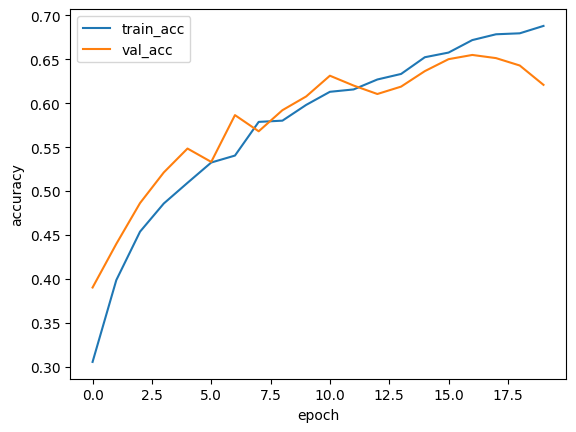

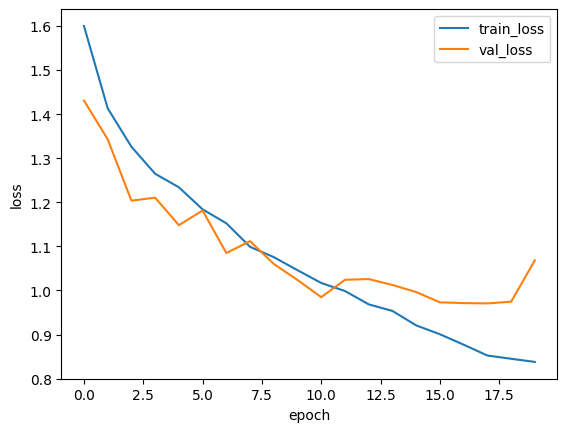

In [19]:
# 10) Courbes d'entraînement
plt.figure()
plt.plot(hist_cnn.history["accuracy"], label="train_acc")
plt.plot(hist_cnn.history["val_accuracy"], label="val_acc")
plt.legend(); plt.xlabel("epoch"); plt.ylabel("accuracy"); plt.show()

plt.figure()
plt.plot(hist_cnn.history["loss"], label="train_loss")
plt.plot(hist_cnn.history["val_loss"], label="val_loss")
plt.legend(); plt.xlabel("epoch"); plt.ylabel("loss"); plt.show()


Test accuracy: 0.5646 | Test loss: 1.2256


<Figure size 600x600 with 0 Axes>

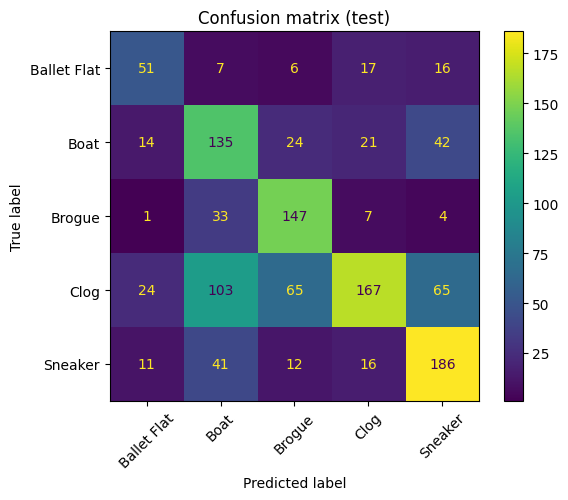

              precision    recall  f1-score   support

 Ballet Flat       0.50      0.53      0.52        97
        Boat       0.42      0.57      0.49       236
      Brogue       0.58      0.77      0.66       192
        Clog       0.73      0.39      0.51       424
     Sneaker       0.59      0.70      0.64       266

    accuracy                           0.56      1215
   macro avg       0.57      0.59      0.56      1215
weighted avg       0.60      0.56      0.56      1215



In [20]:
# 11) Évaluation sur le set de test + matrice de confusion
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

test_loss, test_acc = cnn.evaluate(test_ds_perf, verbose=0)
print(f"Test accuracy: {test_acc:.4f} | Test loss: {test_loss:.4f}")

y_true = []
y_pred = []

for batch_images, batch_labels in test_ds_perf:
    probs = cnn.predict(batch_images, verbose=0)
    preds = np.argmax(probs, axis=1)
    y_true.extend(batch_labels.numpy())
    y_pred.extend(preds)

cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(cm, display_labels=class_names)
plt.figure(figsize=(6,6))
disp.plot(xticks_rotation=45)
plt.title("Confusion matrix (test)")
plt.show()

print(classification_report(y_true, y_pred, target_names=class_names))


In [21]:
# 12) Sauvegarde du modèle
# Format recommandé Keras (portable)
cnn.save("shoes_cnn_scratch.keras")
print("Sauvegardé: shoes_cnn_scratch.keras")


Sauvegardé: shoes_cnn_scratch.keras


In [ ]:
import tensorflow as tf

IMG_SIZE = (224, 224)
BATCH_SIZE = 32
SEED = 123

# Chemins adaptés pour Linux
train_dir = "Shoes Dataset/Train"
val_dir   = "Shoes Dataset/Valid"
test_dir  = "Shoes Dataset/Test"

train_ds = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    seed=SEED
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    val_dir,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    seed=SEED,
    shuffle=False
)

test_ds = tf.keras.utils.image_dataset_from_directory(
    test_dir,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=False
)

class_names = train_ds.class_names
print(class_names)

In [16]:
num_classes = len(class_names)
print("num_classes =", num_classes)


num_classes = 5


In [17]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import MobileNetV2

# 1) Data augmentation (uniquement train)
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.05),
    layers.RandomZoom(0.1),
])

# 2) Base model
base_model = MobileNetV2(
    input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3),
    include_top=False,
    weights="imagenet"
)
base_model.trainable = False

# 3) Modèle complet
tl_model = models.Sequential([
    layers.Input(shape=(IMG_SIZE[0], IMG_SIZE[1], 3)),
    data_augmentation,
    layers.Rescaling(1./255),
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.3),
    layers.Dense(num_classes, activation="softmax")
])

tl_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

early = tf.keras.callbacks.EarlyStopping(
    monitor="val_accuracy", patience=3, restore_best_weights=True
)

hist_tl = tl_model.fit(
    train_ds,                  # important: dataset "train" AVEC augmentation
    validation_data=val_ds,     # val sans augmentation
    epochs=10,
    callbacks=[early]
)


Epoch 1/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 167s 517ms/step - accuracy: 0.6298 - loss: 1.0069 - val_accuracy: 0.7356 - val_loss: 0.7316
Epoch 2/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 147s 471ms/step - accuracy: 0.7330 - loss: 0.7537 - val_accuracy: 0.7460 - val_loss: 0.7054
Epoch 3/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 146s 465ms/step - accuracy: 0.7509 - loss: 0.7098 - val_accuracy: 0.7836 - val_loss: 0.6209
Epoch 4/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 236s 756ms/step - accuracy: 0.7590 - loss: 0.6878 - val_accuracy: 0.7848 - val_loss: 0.6045
Epoch 5/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 267s 854ms/step - accuracy: 0.7620 - loss: 0.6668 - val_accuracy: 0.7836 - val_loss: 0.5968
Epoch 6/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 263s 839ms/step - accuracy: 0.7669 - loss: 0.6708 - val_accuracy: 0.7736 - val_loss: 0.6278
Epoch 7/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 337s 887ms/step - accuracy: 0.7689 - loss: 0.6587 - val_accuracy: 0.7900 - val_loss: 0.6054
Epoch 8/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 263s 841ms/step - accuracy: 0.7742 -

In [19]:
# Débloquer les 30 dernières couches de MobileNet
base_model.trainable = True

for layer in base_model.layers[:-30]:
    layer.trainable = False

# Recompiler avec un learning rate très faible
tl_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

fine_tune_epochs = 5

hist_ft = tl_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=fine_tune_epochs,
    callbacks=[early]
)


Epoch 1/5
313/313 ━━━━━━━━━━━━━━━━━━━━ 272s 839ms/step - accuracy: 0.7608 - loss: 0.7006 - val_accuracy: 0.7436 - val_loss: 0.7826
Epoch 2/5
313/313 ━━━━━━━━━━━━━━━━━━━━ 308s 984ms/step - accuracy: 0.7804 - loss: 0.6313 - val_accuracy: 0.7684 - val_loss: 0.7114
Epoch 3/5
313/313 ━━━━━━━━━━━━━━━━━━━━ 317s 1s/step - accuracy: 0.8004 - loss: 0.5742 - val_accuracy: 0.7892 - val_loss: 0.6409


In [27]:
test_loss, test_acc = tl_model.evaluate(test_ds, verbose=0)
print(f"Test accuracy: {test_acc:.4f} | Test loss: {test_loss:.4f}")


Test accuracy: 0.7687 | Test loss: 0.7453


In [29]:
test_loss, test_acc = tl_model.evaluate(test_ds)
print(f"Test accuracy: {test_acc:.4f}")
print(f"Test loss: {test_loss:.4f}")


38/38 ━━━━━━━━━━━━━━━━━━━━ 14s 361ms/step - accuracy: 0.7687 - loss: 0.7453
Test accuracy: 0.7687
Test loss: 0.7453


<Figure size 800x800 with 0 Axes>

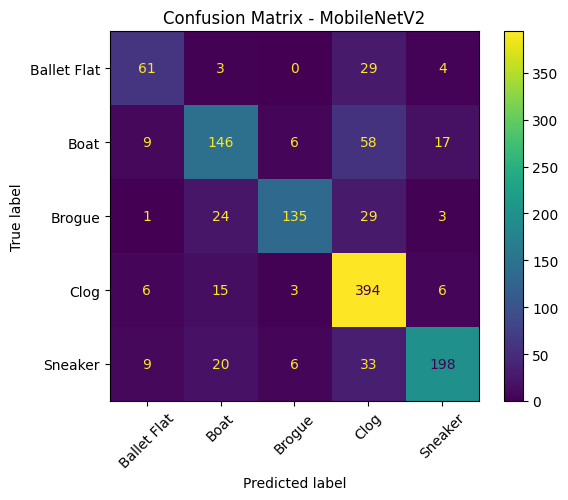

              precision    recall  f1-score   support

 Ballet Flat       0.71      0.63      0.67        97
        Boat       0.70      0.62      0.66       236
      Brogue       0.90      0.70      0.79       192
        Clog       0.73      0.93      0.81       424
     Sneaker       0.87      0.74      0.80       266

    accuracy                           0.77      1215
   macro avg       0.78      0.72      0.75      1215
weighted avg       0.78      0.77      0.77      1215



In [30]:
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
import numpy as np
import matplotlib.pyplot as plt

y_true = []
y_pred = []

for images, labels in test_ds:
    preds = tl_model.predict(images, verbose=0)
    preds = np.argmax(preds, axis=1)
    y_true.extend(labels.numpy())
    y_pred.extend(preds)

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8,8))
disp = ConfusionMatrixDisplay(cm, display_labels=class_names)
disp.plot(xticks_rotation=45)
plt.title("Confusion Matrix - MobileNetV2")
plt.show()

print(classification_report(y_true, y_pred, target_names=class_names))


In [31]:
tl_model.save("shoes_mobilenetv2_finetuned.keras")
print("Modèle sauvegardé ✅")


Modèle sauvegardé ✅


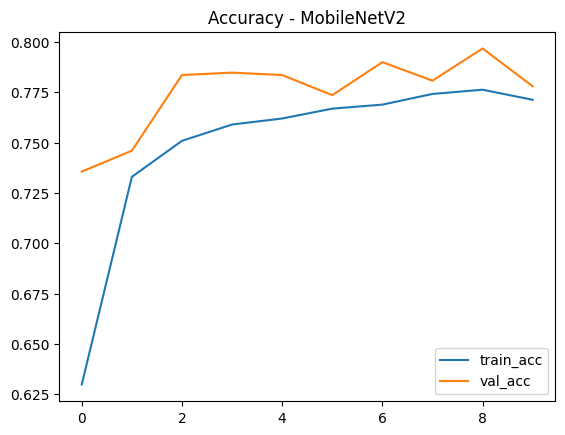

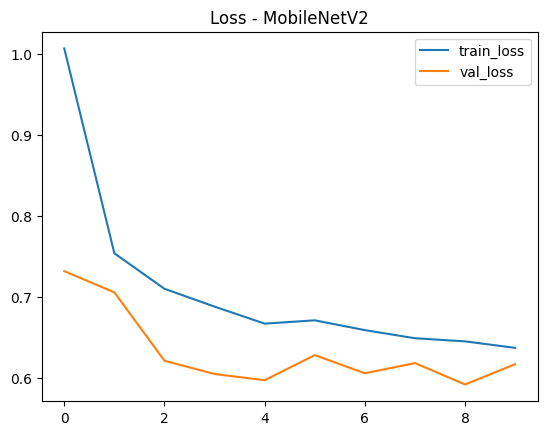

In [32]:
plt.figure()
plt.plot(hist_tl.history["accuracy"], label="train_acc")
plt.plot(hist_tl.history["val_accuracy"], label="val_acc")
plt.legend(); plt.title("Accuracy - MobileNetV2"); plt.show()

plt.figure()
plt.plot(hist_tl.history["loss"], label="train_loss")
plt.plot(hist_tl.history["val_loss"], label="val_loss")
plt.legend(); plt.title("Loss - MobileNetV2"); plt.show()


In [36]:
import tensorflow as tf
t1_model = tf.keras.models.load_model("shoes_mobilenetv2_finetuned.keras")


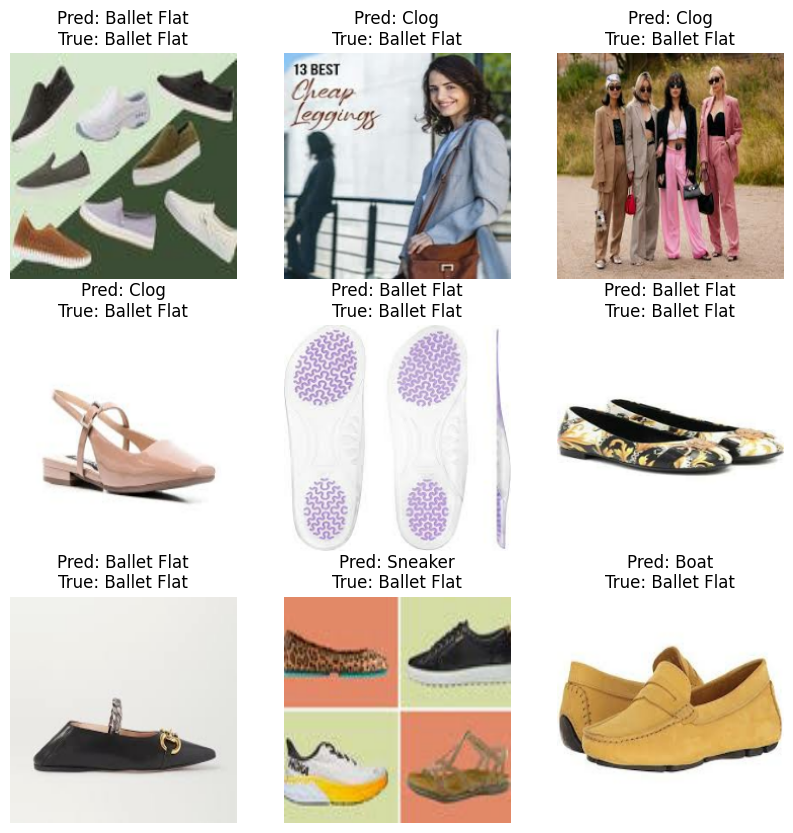

In [37]:
import numpy as np
import matplotlib.pyplot as plt

for images, labels in test_ds.take(1):
    probs = t1_model.predict(images, verbose=0)
    preds = np.argmax(probs, axis=1)

    plt.figure(figsize=(10,10))
    for i in range(9):
        ax = plt.subplot(3, 3, i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(f"Pred: {class_names[preds[i]]}\nTrue: {class_names[int(labels[i])]}")
        plt.axis("off")
    plt.show()



<Figure size 700x700 with 0 Axes>

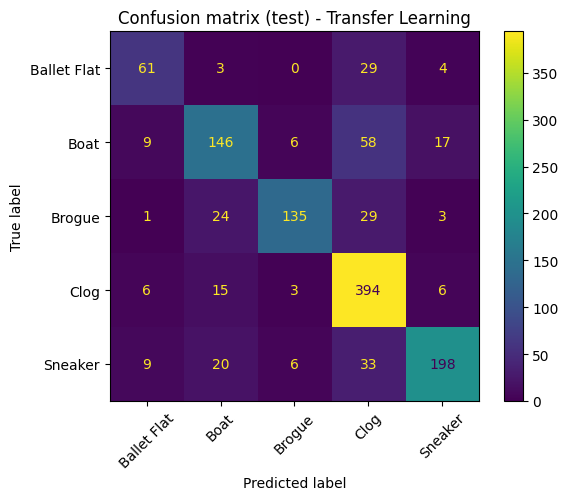

              precision    recall  f1-score   support

 Ballet Flat       0.71      0.63      0.67        97
        Boat       0.70      0.62      0.66       236
      Brogue       0.90      0.70      0.79       192
        Clog       0.73      0.93      0.81       424
     Sneaker       0.87      0.74      0.80       266

    accuracy                           0.77      1215
   macro avg       0.78      0.72      0.75      1215
weighted avg       0.78      0.77      0.77      1215



In [21]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

# Récupération des labels vrais + prédictions
y_true = []
y_pred = []

for batch_images, batch_labels in test_ds:
    probs = tl_model.predict(batch_images, verbose=0)
    preds = np.argmax(probs, axis=1)
    y_true.extend(batch_labels.numpy())
    y_pred.extend(preds)

cm = confusion_matrix(y_true, y_pred)

disp = ConfusionMatrixDisplay(cm, display_labels=class_names)
plt.figure(figsize=(7,7))
disp.plot(xticks_rotation=45)
plt.title("Confusion matrix (test) - Transfer Learning")
plt.show()

print(classification_report(y_true, y_pred, target_names=class_names))


In [23]:
#nouvelle sauvegarde du modèle 
tl_model.save("shoes_mobilenetv2_finetuned.keras")
print("Sauvegardé: shoes_mobilenetv2_finetuned.keras")


Sauvegardé: shoes_mobilenetv2_finetuned.keras


In [24]:
# je sauvegarde les class_names au cas ou 
import json
with open("class_names.json", "w") as f:
    json.dump(class_names, f)
print("Sauvegardé: class_names.json")


Sauvegardé: class_names.json


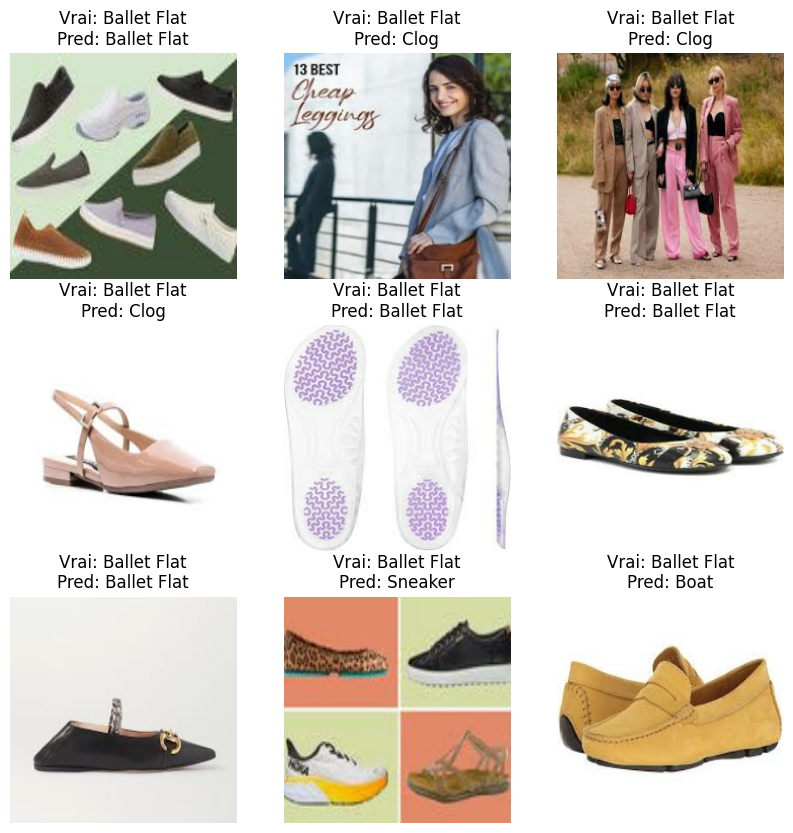

In [26]:
import matplotlib.pyplot as plt
import numpy as np

for images, labels in test_ds.take(1):
    probs = tl_model.predict(images, verbose=0)
    preds = np.argmax(probs, axis=1)

    plt.figure(figsize=(10,10))
    for i in range(9):
        ax = plt.subplot(3,3,i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        true = class_names[labels[i].numpy()]
        pred = class_names[preds[i]]
        plt.title(f"Vrai: {true}\nPred: {pred}")
        plt.axis("off")
    plt.show()


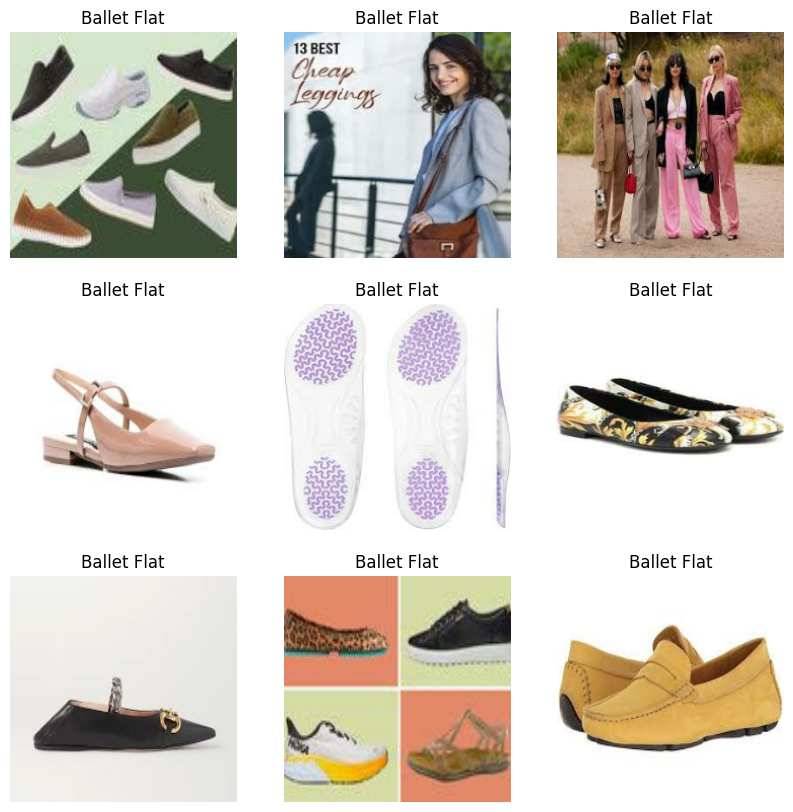

In [11]:
import matplotlib.pyplot as plt

for images, labels in test_ds.take(1):
    plt.figure(figsize=(10,10))
    for i in range(9):
        ax = plt.subplot(3,3,i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")
    plt.show()



NameError: name 'num_classes' is not defined

## Étape supérieure (optionnelle mais recommandée)
Transfer Learning (MobileNetV2/EfficientNet) pour améliorer les performances. , voir le  `val_accuracy` et passer à la suite
